<a href="https://colab.research.google.com/github/EnricoMiche1210760/toxic_comments_filter/blob/main/src/progetto_toxic_comments_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

The goal of this project is to build a model able to filter user comments based on the degree of harmfulness of the language:
1. Preprocess the text by removing the set of tokens that do not provide significant semantic contribution
2. Transform the text corpus into sequences
3. Build a Deep Learning model including recurrent layers for a multilabel classification task
4. In prediction time, the model must return a vector containing a 1 or a 0 corresponding to each label present in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In this way, a non-harmful comment will be classified by a vector of only 0s [0,0,0,0,0,0]. On the contrary, a dangerous comment will have at least one 1 among the 6 labels.

In [38]:
import pandas as pd
import nltk
import spacy
import numpy as np
import os
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, MaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D
from keras.backend import clear_session


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


COLAB = False
if "google.colab" in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')

In [2]:
if COLAB == True:
    BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
    storage_folder = "./"
else:
    BASE_URL = "../data/"
    storage_folder = BASE_URL
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

## Dataset
First of all we can analyze the dataset that we have to use for this project. The dataset is composed of 159571 comments and 8 columns. The columns are:
- comment_text: the text of the comment
- toxic: binary label that indicates if the comment is toxic
- severe_toxic: binary label that indicates if the comment is severely toxic
- obscene: binary label that indicates if the comment is obscene
- threat: binary label that indicates if the comment is a threat
- insult: binary label that indicates if the comment is an insult
- identity_hate: binary label that indicates if the comment is an identity hate
- sum_injurious: sum of the labels toxic, severe_toxic, obscene, threat, insult, identity_hate

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


We can check all the comments that have 2 labels set to 1. 

In [4]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [5]:
len(df)

159571

### Dataset preprocessing
The dataset is already clean, so we can start with the preprocessing of the text. We decided to remove the set of tokens that do not provide significant semantic contribution, plus the stopwords and the punctuation.
To remove stopwords and punctuation we use the library nltk, while to remove the set of tokens that do not provide significant semantic contribution we use the library spacy, loading the model 'en_core_web_sm'.
Since the corpus is very large, we also decided to remove words smaller than 3 characters.

In [6]:
df_text = np.array(df['comment_text'])
type(df_text)

try:
    nlp = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
try:
    eng_stopwords = nltk.corpus.stopwords.words('english')
except:
    nltk.download('stopwords')
    eng_stopwords = nltk.corpus.stopwords.words('english')
try:
    _ = nltk.tokenize.word_tokenize('test')
except:
    nltk.download('punkt')

def preprocess_text_and_store(text, doc_store=None, store=False):
    preprocessed_text = np.empty(len(text), dtype=object)
    if doc_store is None or doc_store not in os.listdir(storage_folder):
        counter = 0
        for i in range(len(text)):
            process_words = []
            text[i] = text[i].replace('\d', ' ')
            for word in nltk.word_tokenize(nlp(text[i].lower()).text):
                if word.isalpha() and word not in eng_stopwords and len(str(word)) >= 3:
                    process_words.append(word)
            preprocessed_text[counter] = ' '.join(process_words)
            counter += 1
    else:
        preprocessed_text = np.array(pd.read_csv(storage_folder+doc_store)['comment_text'])
    if store and not COLAB:
        pd.DataFrame(data = {"comment_text":preprocessed_text}).to_csv(BASE_URL+doc_store)

    return preprocessed_text

preprocessed_text= preprocess_text_and_store(df_text, doc_store="preprocessed_text.csv", store=True)


numpy.ndarray

In [7]:
df_text[0]
preprocessed_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [8]:
df = df.drop(columns=['comment_text'])

In [9]:
df.head(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [10]:
df['sum_injurious'].unique()

array([0, 4, 1, 3, 2, 5, 6])

In [11]:
import matplotlib.pyplot as plt

def show_number(plot, barplot):
    for i in range(len(barplot)):
        height = barplot[i].get_height()
        plot.text(barplot[i].get_x() + barplot[i].get_width()/2, height, height, ha='center', va='bottom')

def plot_bar(columns, rows, figsize=(8,5), title:str=None, xlabel:str=None, ylabel:str=None, color='blue', xticks_settings=None, yticks_settings=None):
    plt.figure(figsize=figsize)
    barplot = plt.bar(columns, rows, color=color)
    plt.yticks(**yticks_settings)
    plt.xticks(**xticks_settings)
    if title is not None:
        plt.title(title, fontsize=15)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=10)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=10)
    show_number(plt, barplot)
    plt.show();


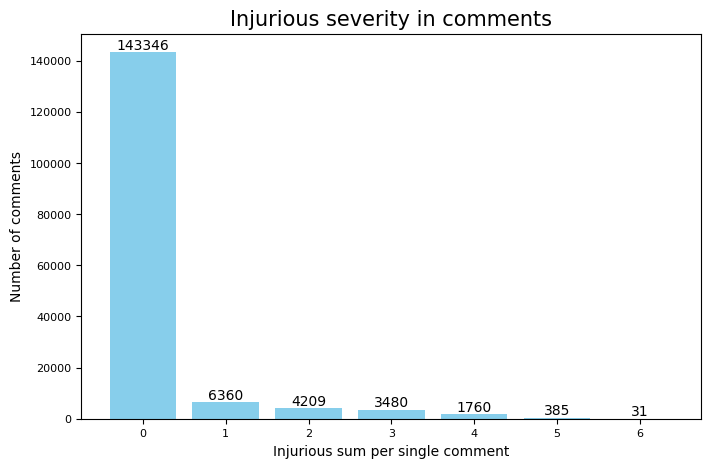

In [12]:
col_names = np.sort(df['sum_injurious'].unique())
comments_per_injurious = df['sum_injurious'].value_counts()

plot_bar(col_names, comments_per_injurious, title='Injurious severity in comments', \
         xlabel='Injurious sum per single comment', ylabel='Number of comments', color='skyblue', \
            xticks_settings={'fontsize':8}, yticks_settings={'fontsize':8})



In [13]:
injurious = df.drop(columns=['sum_injurious'])
non_injurious = pd.Series(data=comments_per_injurious[0], index=["none"])
injurious_type_sum = pd.concat([injurious.sum(axis=0), non_injurious]).sort_values(ascending=False)
injurious_type_sum

none             143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64

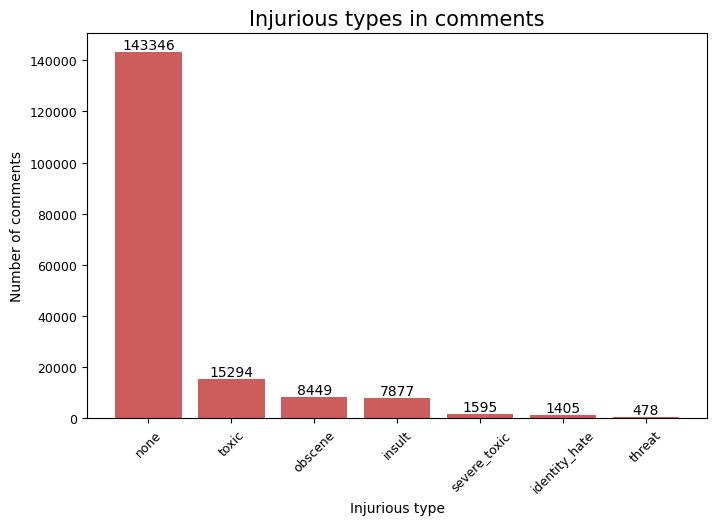

In [14]:
plot_bar(injurious_type_sum.index, injurious_type_sum, title='Injurious types in comments', \
         xlabel='Injurious type', ylabel='Number of comments', color='indianred', \
            xticks_settings={'rotation':45, 'fontsize':9}, yticks_settings={'fontsize':9})

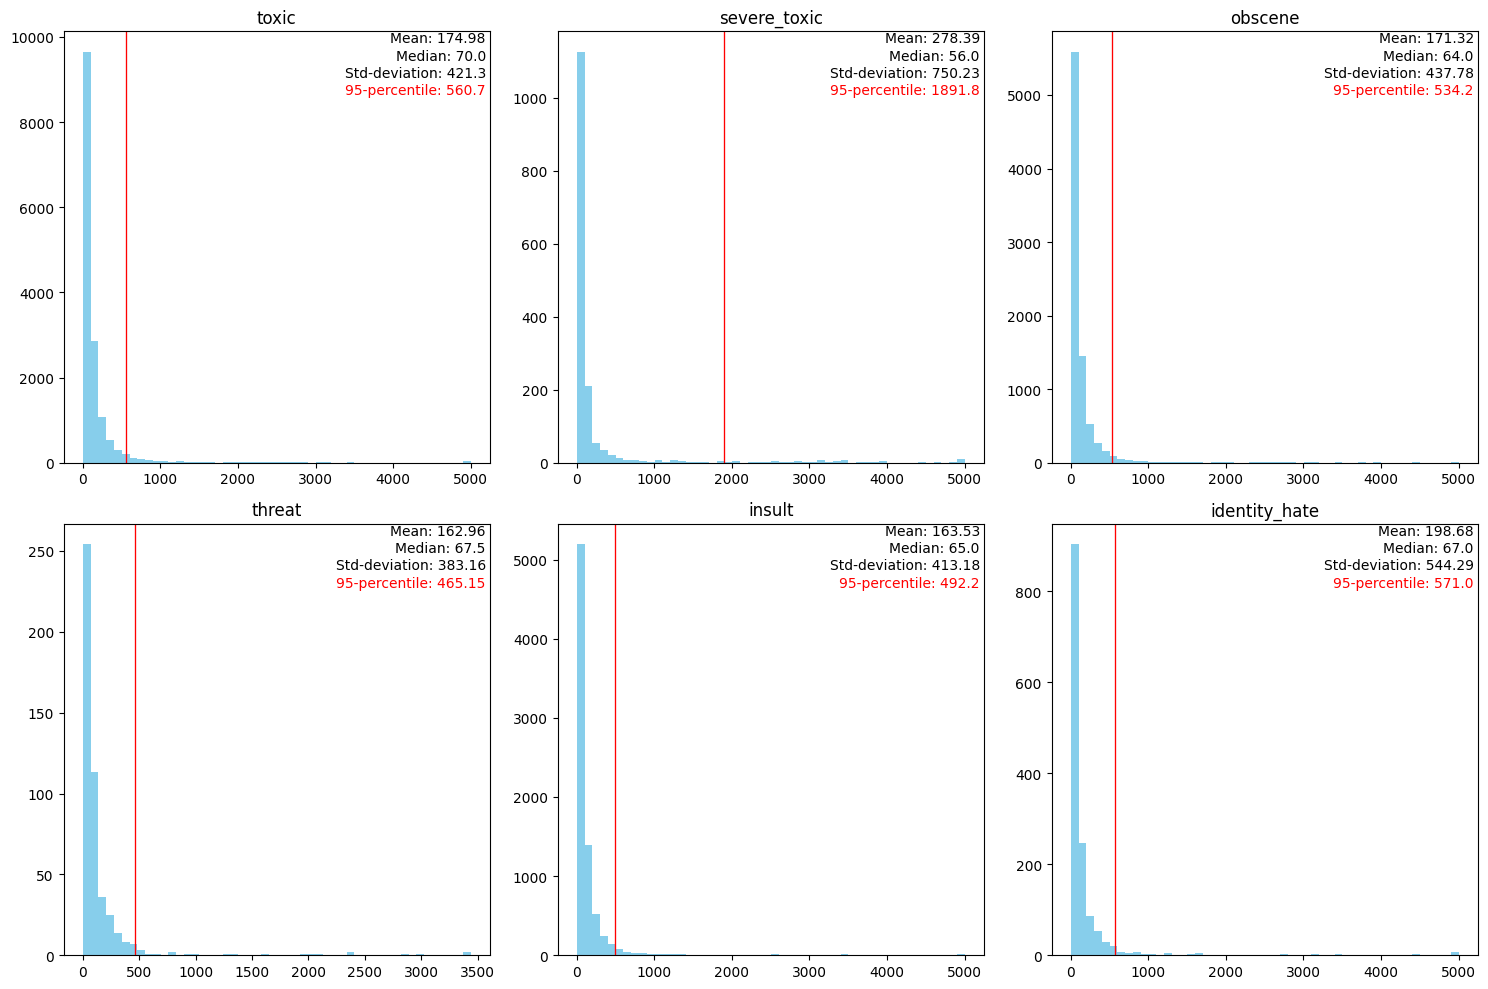

In [15]:
axes = []
fig, axes = plt.subplots(2, 3, figsize=(15,10))

len_sentences = np.array([len(str(sentence)) for sentence in preprocessed_text])

for i, col in enumerate(injurious.columns):
    len_sentences_col = len_sentences[df[df[col] == 1].index]
    ax = axes[i//3, i%3]
    ax.hist(len_sentences_col, bins=50, color='skyblue')
    ax.set_title(col)
    ax.text(.99, 1, f"Mean: {round(len_sentences_col.mean(), 2)}", transform=ax.transAxes, ha='right', va='top')
    ax.text(.99, .96, f"Median: {round(np.median(len_sentences_col), 2)}", transform=ax.transAxes, ha='right', va='top')
    ax.text(.99, .92, f"Std-deviation: {round(len_sentences_col.std(), 2)}", transform=ax.transAxes, ha='right', va='top')
    ax.text(.99, .88, f"95-percentile: {round(np.percentile(len_sentences_col, 95), 2)}", transform=ax.transAxes, ha='right', va='top', color='red')
    ax.axvline(x=np.percentile(len_sentences_col, 95), color='red', linewidth=.95)

fig.tight_layout()
plt.show();


In [16]:
injurious[0:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [17]:
from sklearn.model_selection import train_test_split

def train_test_val_split(data, labels=None, test_size=0.2, val_size=0.1, random_state=42):
    if labels is None:
        data, labels = data
    corpus, X_test, train_labels, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(corpus, train_labels, test_size=val_size/(1-test_size), random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)

    return X_train.astype(str).tolist(), X_test.astype(str).tolist(), X_val.astype(str).tolist(), y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.3, val_size=0.3)


X_train[0:3]
y_train[0:3]

['writing biographies want create biography please first read blp follow guidance put front name way removed per guidelines read see wikipedia article wizard advises bit editing first',
 'asking already initiated another sock puppet investigation please wait verdict way proves hound orchestrated total attack wiki personality purpose eliminating wiki opinion latest dispute article albania alexikoua remove sourced consensual material cia world fact book official housing census united nations confirm already proven rows meat alexikoua addition noticed unethical act user alexikoua forward admin opinion comment removed talk page demonstrated purpose changing artificially established consensus denied alexikoua know yet wiki definition sure get trying say days block verdict account',
 'checked pome indeed right legend fate amrod telufinwë one burned ships amras pityafinwë ambarussa survived presumably still died third kinslaying follow pome strictly curufin fëanor fourth son caranthir fifth']

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

type(X_train)

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

tokenizer.word_counts


list

OrderedDict([('writing', 933),
             ('biographies', 331),
             ('want', 4648),
             ('create', 1096),
             ('biography', 296),
             ('please', 11964),
             ('first', 4370),
             ('read', 3263),
             ('blp', 282),
             ('follow', 639),
             ('guidance', 86),
             ('put', 2474),
             ('front', 283),
             ('name', 4426),
             ('way', 4442),
             ('removed', 2632),
             ('per', 977),
             ('guidelines', 1313),
             ('see', 8559),
             ('wikipedia', 17657),
             ('article', 22694),
             ('wizard', 139),
             ('advises', 9),
             ('bit', 1316),
             ('editing', 3873),
             ('asking', 486),
             ('already', 2164),
             ('initiated', 47),
             ('another', 2622),
             ('sock', 477),
             ('puppet', 169),
             ('investigation', 180),
             ('wai

In [19]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)
X_val   = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)

Vocabulary size:  92361


In [20]:
X_train[0]

[364,
 27,
 304,
 6,
 33,
 59,
 555,
 95,
 31,
 30,
 83,
 340,
 261,
 59,
 9,
 3,
 1,
 260,
 44,
 33]

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = len(max(X_train, key=len))
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

X_train[0:5]
X_train.shape
y_train.shape



array([[364,  27, 304, ...,   0,   0,   0],
       [713, 117,  84, ...,   0,   0,   0],
       [524,  62,   7, ...,   0,   0,   0],
       [  6,  75, 153, ...,   0,   0,   0],
       [389, 900, 325, ...,   0,   0,   0]], dtype=int32)

(63828, 1250)

(63828, 6)

In [22]:


def LSTM_simple_model(vocab_size, maxlen, dense_units=1, activation='softmax'):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim=150, input_length=maxlen))
    model.add(Dropout(0.65)) #avoid overfitting
    model.add(LSTM(units=50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.35))
    model.add(Dense(dense_units, activation=activation))
    return model

class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['val_accuracy'] > 0.97 and epoch + 1 > 5:
            self.model.stop_training = True
            print('\nStop training at epoch:', epoch+1)


In [23]:
clear_session()
early_stopping = EarlyStopping()

base_model_name="base_LSTM.plk"
import pickle
from tensorflow.keras.models import load_model
if base_model_name not in os.listdir(storage_folder):
    base_model = LSTM_simple_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
    base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    if COLAB:
      base_model = load_model("./models/LSTM_model.keras")
    else:
      base_model = load_model("../models/LSTM_model.keras")

    trained_model = pickle.load(open(storage_folder+"/"+base_model_name, 'rb'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13854150  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 lstm (LSTM)                 (None, 1250, 50)          40200     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

In [24]:
if base_model_name not in os.listdir(storage_folder):
    trained_model = base_model.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    pickle.dump(trained_model, open(storage_folder+"/"+base_model_name, 'wb'))
    if COLAB:
        base_model.save("./models/LSTM_model.keras")
    else:
        base_model.save("../models/LSTM_model.keras")


In [25]:
trained_model.history

{'loss': [0.09740230441093445,
  0.07106531411409378,
  0.06832749396562576,
  0.06667742133140564,
  0.06500918418169022,
  0.06405728310346603],
 'accuracy': [0.8324089646339417,
  0.96919846534729,
  0.9849752187728882,
  0.9888450503349304,
  0.98867267370224,
  0.9900043606758118],
 'val_loss': [0.06954783201217651,
  0.06659490615129471,
  0.06652738153934479,
  0.06571706384420395,
  0.06583882868289948,
  0.06716660410165787],
 'val_accuracy': [0.9938167333602905,
  0.9938167333602905,
  0.9938167333602905,
  0.9936704635620117,
  0.9925215840339661,
  0.9937122464179993]}

In [26]:
base_model.evaluate(X_test, y_test)

1496/1496 [==============================] - 138s 92ms/step - loss: 0.0675 - accuracy: 0.9939


[0.06746478378772736, 0.993879497051239]

In [27]:
def convert_probability_to_value(arr:np.array, threshold=.5):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j] = 1 if arr[i][j] > threshold else 0
    return arr

In [28]:
y_pred = convert_probability_to_value(base_model.predict(X_test))


  38/1496 [..............................] - ETA: 2:22

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def print_confusion_matrix(y_test, y_pred, columns):
    fig, axes = plt.subplots(2, 3, figsize=(18, 9))
    print(columns)
    for i, col in enumerate(columns):
        ax = axes[i//3, i%3]
        sns.heatmap(confusion_matrix(y_test.T[i], y_pred.T[i]), annot=True, fmt='d', cmap="Greens", ax=ax)
        ax.set_title(f"Confusion matrix for {col}")
        ax.set_xlabel("Predicted severity")
        ax.set_ylabel("Severity")
        ax.xaxis.set_ticklabels([f'Pred non {col}', f'Pred {col}'])
        ax.yaxis.set_ticklabels([f'Non {col}', f'{col}'])

    plt.subplots_adjust(hspace=0.3)
    plt.show()

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


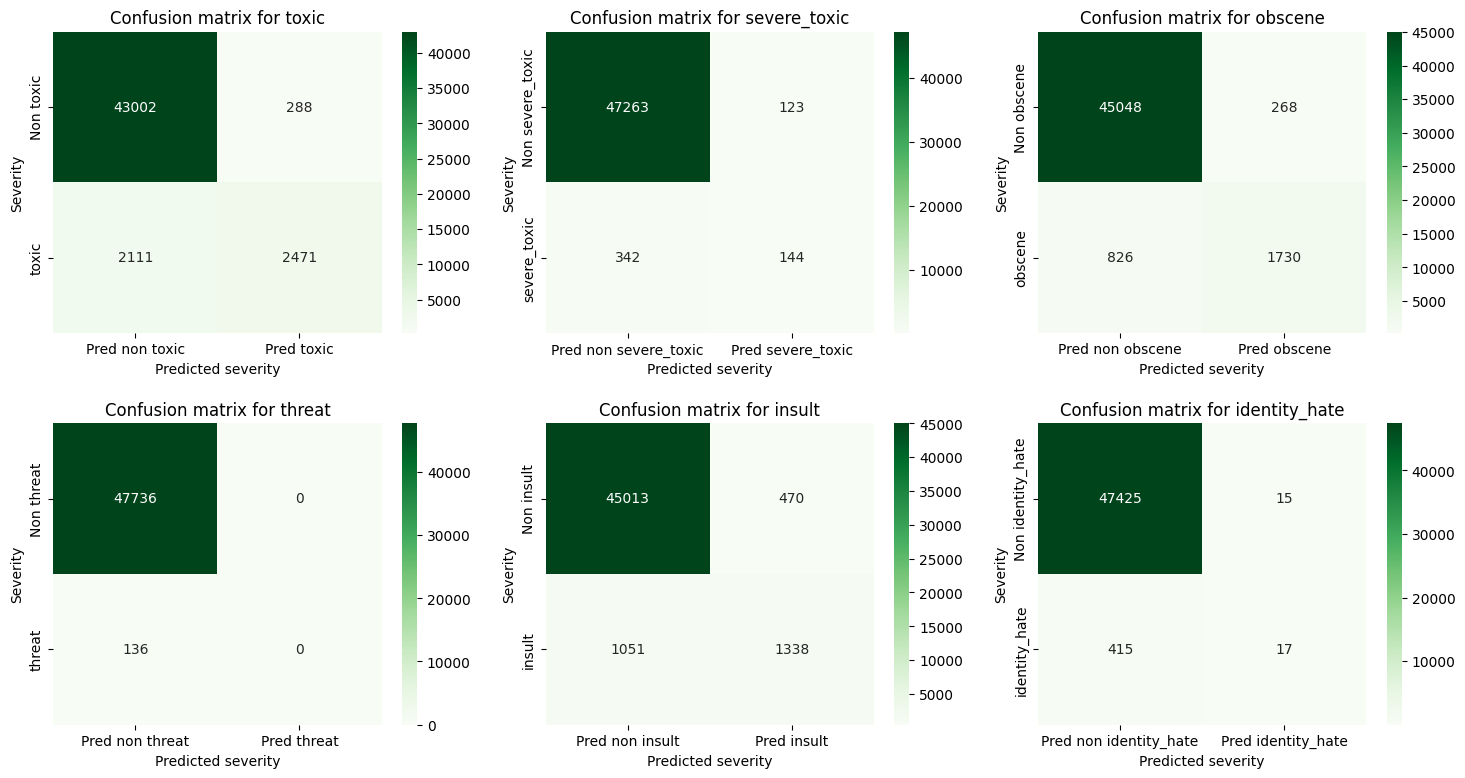

In [ ]:
print_confusion_matrix(y_test, y_pred, injurious.columns)

## RNN with GRU layer

In [33]:
#RNN model with GRU layer and 4 hidden layers
from tensorflow.keras.layers import GRU, SimpleRNN, Dropout

clear_session()
rnn_gru_model_keras = "rnn_gru_model.keras"
rnn_gru_model_history = "history_rnn_gru.plk"
answer = ""
models_dir = ""
if COLAB:
  models_dir="./models"
else:
  models_dir="../models"

if rnn_gru_model_keras in os.listdir(models_dir):
    answer = str(input(f"FOund Keras model {rnn_gru_model_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        rnn_gru_model = Sequential()
        rnn_gru_model.add(Embedding(input_dim = vocab_size, output_dim=100, input_length=maxlen))
        rnn_gru_model.add(Dropout(0.85))
        rnn_gru_model.add(GRU(units=100, return_sequences=True))
        rnn_gru_model.add(Dropout(0.5))
        rnn_gru_model.add(GRU(units=100, return_sequences=True))
        rnn_gru_model.add(Dropout(0.35))
        rnn_gru_model.add(SimpleRNN(units=50))
        rnn_gru_model.add(Dropout(0.35))
        rnn_gru_model.add(Dense(32, activation='relu'))
        rnn_gru_model.add(Dropout(0.15))
        rnn_gru_model.add(Dense(len(y_train[0]), activation='sigmoid'))

        rnn_gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        rnn_gru_model = load_model("../models/"+rnn_gru_model_keras)


rnn_gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13854150  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 gru (GRU)                   (None, 1250, 128)         107520    
                                                                 
 dropout_1 (Dropout)         (None, 1250, 128)         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2

In [ ]:
if answer.lower() == 'y' or answer == 'yes':
    history_rnn_gru = rnn_gru_model.fit(X_train, y_train,
                        epochs=5, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    pickle.dump(history_rnn_gru, open(storage_folder+"/"+"history_rnn_gru.plk", 'wb'))
    rnn_gru_model.save(models_dir+"/rnn_gru_model.keras")


else:
    history_rnn_gru = pickle.load(open(storage_folder+"/"+rnn_gru_model_history, 'rb'))

history_rnn_gru.history

{'loss': [0.17153529822826385,
  0.14572514593601227,
  0.1444680094718933,
  0.14355094730854034,
  0.1432206630706787],
 'accuracy': [0.8256720900535583,
  0.985366940498352,
  0.9944381713867188,
  0.9945164918899536,
  0.9945008754730225],
 'val_loss': [0.15342450141906738,
  0.14368604123592377,
  0.14170333743095398,
  0.14127565920352936,
  0.14155834913253784],
 'val_accuracy': [0.9938167333602905,
  0.9938167333602905,
  0.9938167333602905,
  0.9938167333602905,
  0.9938167333602905]}

In [ ]:
y_pred_rnn_gru = convert_probability_to_value(rnn_gru_model.predict(X_test))

1496/1496 [==============================] - 377s 252ms/step


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


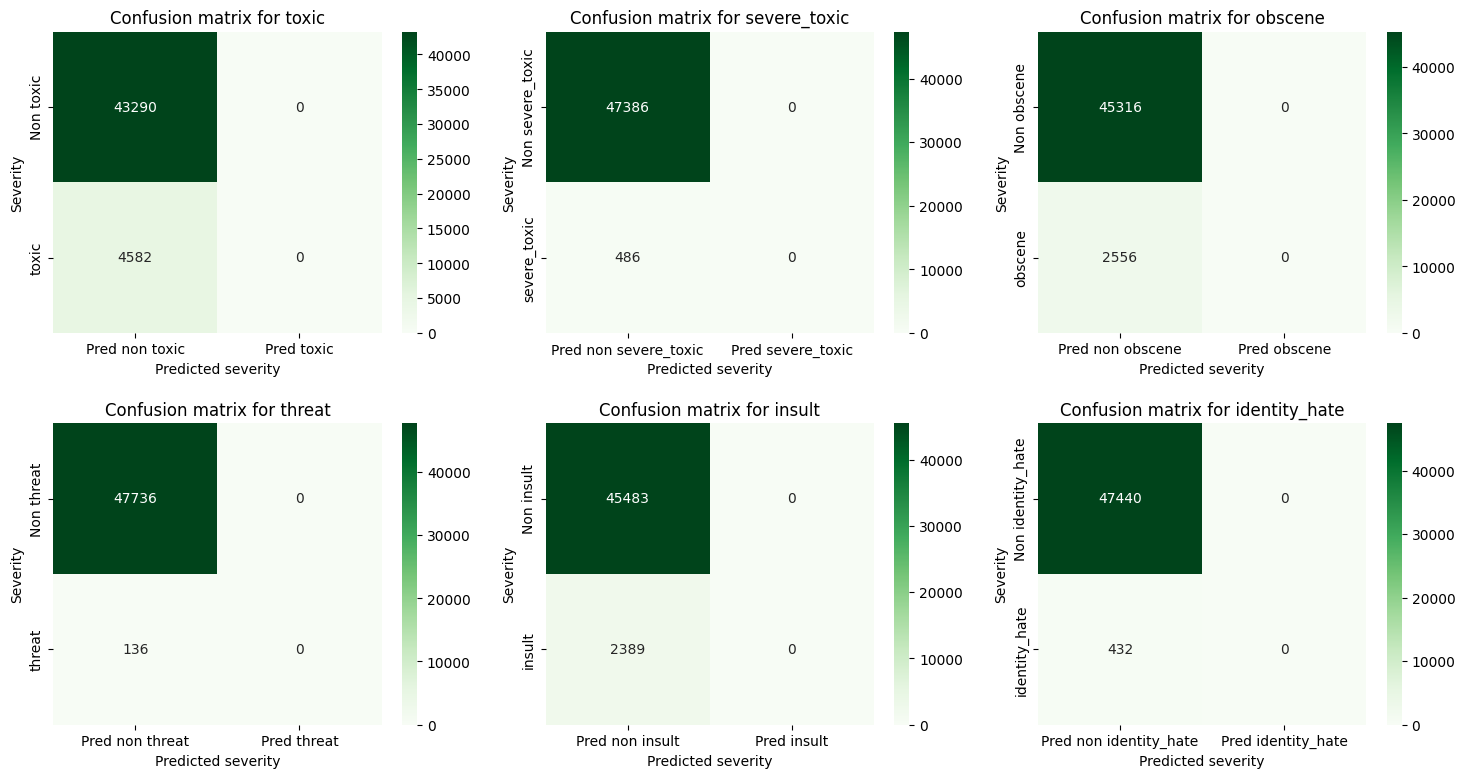

In [ ]:
print_confusion_matrix(y_test, y_pred_rnn_gru, injurious.columns)

## Model with LSTM and Convolutional layer

In [ ]:

cnn_model_keras = "cnn_model.keras"
cnn_model_history = "history_cnn.plk"

if cnn_model_keras in os.listdir(models_dir):
    answer = str(input(f"FOund Keras model {cnn_model_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        clear_session()
        cnn_model = Sequential()
        cnn_model.add(Embedding(input_dim = vocab_size, output_dim=150, input_length=maxlen))
        cnn_model.add(Dropout(0.75))
        cnn_model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
        cnn_model.add(Dropout(0.5))
        cnn_model.add(Conv1D(64, 5, activation='relu'))
        cnn_model.add(GlobalMaxPool1D())
        cnn_model.add(Dropout(0.35))
        cnn_model.add(Dense(32, activation='relu'))
        cnn_model.add(Dense(len(y_train[0]), activation='sigmoid'))

        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    else:
        cnn_model = load_model("../models/"+cnn_model_keras)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13854150  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1250, 200)         200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1250, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, 1246, 64)          64064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                        

In [ ]:
if answer.lower() == 'y' or answer == 'yes':
    history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    pickle.dump(history_cnn, open(storage_folder+"/"+cnn_model_history, 'wb'))
    cnn_model.save(models_dir+'/'+cnn_model_keras)   
else:
    history_cnn = pickle.load(open(storage_folder+"/"+cnn_model_history, 'rb'))

1496/1496 [==============================] - 559s 373ms/step
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


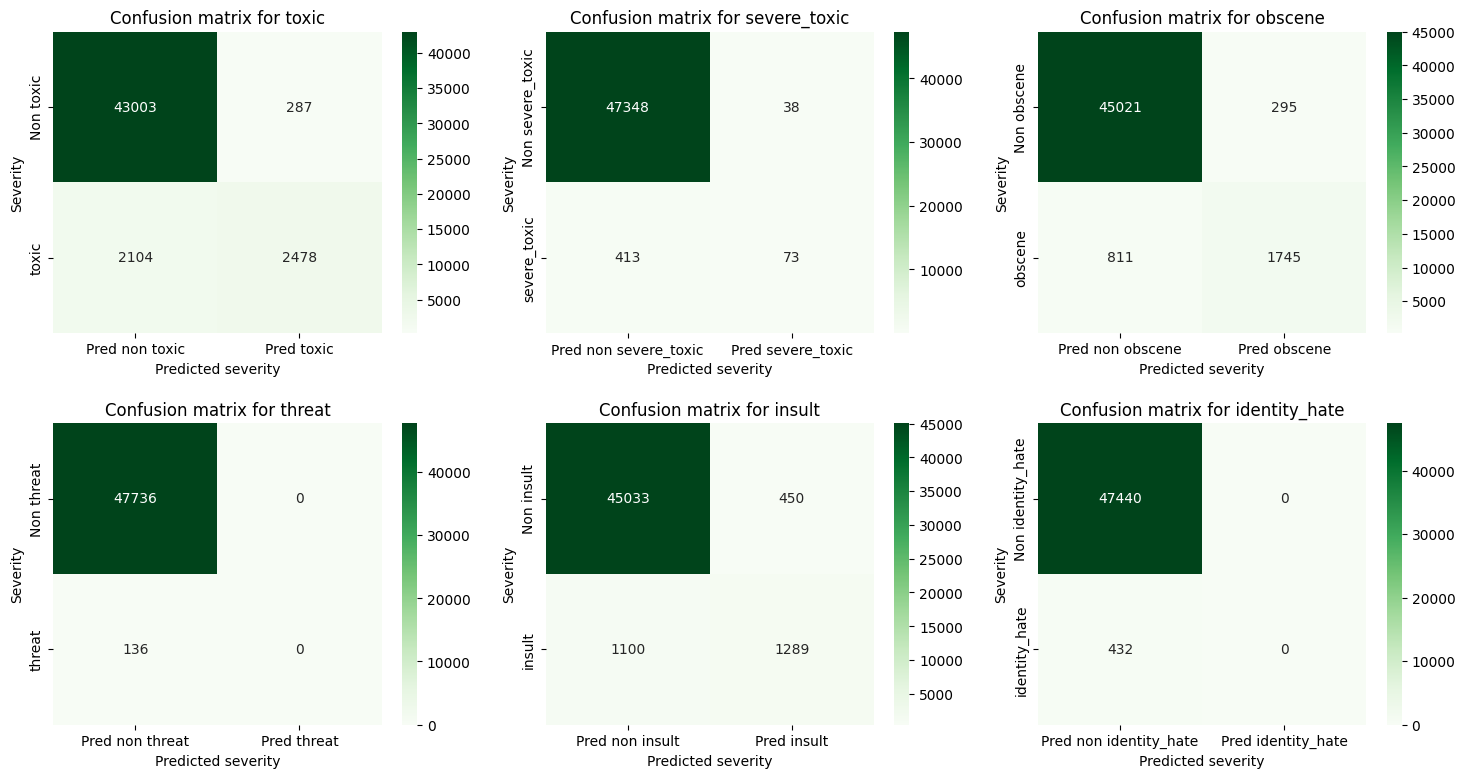

In [ ]:
y_pred_cnn = convert_probability_to_value(cnn_model.predict(X_test))
print_confusion_matrix(y_test, y_pred_cnn, injurious.columns)

## Weighted loss function

In [29]:
@tf.keras.saving.register_keras_serializable()#senza specificare un paramentro, sovvrascrive loss
def weighted_binary_crossentropy(w0, w1):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        _w0 = tf.constant(w0, dtype=tf.float32)
        _w1 = tf.constant(w1, dtype=tf.float32)
        loss = -_w0 * y_true * tf.math.log(y_pred) - _w1 * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

w0 = [(1/np.sum(y_train.T[i] == 0)) * (len(y_train) /2) for i in range(len(y_train[0]))]
w1 = [(1/np.sum(y_train.T[i] == 1)) * (len(y_train) /2) for i in range(len(y_train[0]))] 
w0, w1

([0.553370786516854,
  0.5051202101897723,
  0.5278618567955142,
  0.5013825174385723,
  0.5258440295925261,
  0.5044096728307255],
 [5.184210526315789,
  49.32612055641422,
  9.472840605520927,
  181.32954545454547,
  10.173414089894804,
  57.193548387096776])

In [30]:
y_train.T[5]
range(len(y_train[0]))

array([0, 0, 0, ..., 0, 0, 0])

range(0, 6)

## ANOTHER MODEL

In [39]:
from tensorflow.keras.layers import MaxPooling1D
clear_session()

cnn_model_2_keras = "cnn_model_2.keras"
cnn_model_2_history = "history_cnn_2.plk"

def CNN_model_2(vocab_size, maxlen, dense_units=1, activation='softmax'):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim=256, input_length=maxlen))
    model.add(Dropout(0.75))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(dense_units, activation=activation))
    return model


if cnn_model_2_keras in os.listdir(models_dir):
    answer = str(input(f"FOund Keras model {rnn_gru_model_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        clear_session()
        cnn_model_2 = CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')        
        cnn_model_2.compile(optimizer='adam', loss=weighted_binary_crossentropy(w0, w1), metrics=['accuracy'])

    else:
        custom_objects = {'loss': weighted_binary_crossentropy(w0, w1)}
        cnn_model_2 = load_model("../models/"+cnn_model_2_keras, custom_objects=custom_objects)
else:
    clear_session()
    cnn_model_2 = CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')        
    cnn_model_2.compile(optimizer='adam', loss=weighted_binary_crossentropy(w0, w1), metrics=['accuracy'])


cnn_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 256)         23644416  
                                                                 
 dropout (Dropout)           (None, 1250, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, 1250, 128)         98432     
                                                                 
 max_pooling1d (MaxPooling1  (None, 625, 128)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [43]:
answer = "y"
if answer.lower() == 'y' or answer == 'yes':
    history_cnn_2 = cnn_model_2.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    pickle.dump(history_cnn_2, open(storage_folder+"/"+cnn_model_2_history, 'wb'))
    cnn_model_2.save(models_dir+'/'+cnn_model_2_keras)   
else:
    history_cnn_2 = pickle.load(open(storage_folder+"/"+cnn_model_2_history, 'rb'))

Epoch 1/10
998/998 [==============================] - 779s 779ms/step - loss: 0.5498 - accuracy: 0.7701 - val_loss: 0.1302 - val_accuracy: 0.9938
Epoch 2/10
998/998 [==============================] - 779s 781ms/step - loss: 0.1375 - accuracy: 0.9715 - val_loss: 0.1300 - val_accuracy: 0.9938
Epoch 3/10
998/998 [==============================] - 779s 781ms/step - loss: 0.1359 - accuracy: 0.9925 - val_loss: 0.1323 - val_accuracy: 0.9938
Epoch 4/10
998/998 [==============================] - 781s 783ms/step - loss: 0.1350 - accuracy: 0.9943 - val_loss: 0.1334 - val_accuracy: 0.9938
Epoch 5/10
998/998 [==============================] - 782s 784ms/step - loss: 0.1344 - accuracy: 0.9944 - val_loss: 0.1323 - val_accuracy: 0.9938
Epoch 6/10
998/998 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9945
Stop training at epoch: 6
998/998 [==============================] - 781s 783ms/step - loss: 0.1340 - accuracy: 0.9945 - val_loss: 0.1364 - val_accuracy: 0.9938


NameError: name 'cnn_model' is not defined

In [45]:
y_pred_cnn_2 = convert_probability_to_value(cnn_model_2.predict(X_test))
print_confusion_matrix(y_test, y_pred_cnn_2, injurious.columns)

1496/1496 [==============================] - 141s 94ms/step


NameError: name 'print_confusion_matrix' is not defined